In [1]:
# EECS 445 - Winter 2018
# Project 1 - project1.py

import pandas as pd
import numpy as np
import itertools
import string
import random

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn import metrics
from matplotlib import pyplot as plt

def load_data(fname):
    """
    Reads in a csv file and return a dataframe. A dataframe df is similar to dictionary.
    You can access the label by calling df['label'], the content by df['content']
    the rating by df['rating']
    """
    return pd.read_csv(fname)


def get_split_binary_data():
    """
    Reads in the data from data/dataset.csv and returns it using
    extract_dictionary and generate_feature_matrix split into training and test sets.
    The binary labels take two values:
        -1: poor/average
         1: good
    Also returns the dictionary used to create the feature matrices.
    """
    fname = "data/dataset.csv"
    dataframe = load_data(fname)
    dataframe = dataframe[dataframe['label'] != 0]
    positiveDF = dataframe[dataframe['label'] == 1].copy()
    negativeDF = dataframe[dataframe['label'] == -1].copy()
    X_train = pd.concat([positiveDF[:500], negativeDF[:500]]).reset_index(drop=True).copy()
    dictionary = extract_dictionary(X_train)
    X_test = pd.concat([positiveDF[500:700], negativeDF[500:700]]).reset_index(drop=True).copy()
    Y_train = X_train['label'].values.copy()
    Y_test = X_test['label'].values.copy()
    X_train = generate_feature_matrix(X_train, dictionary)
    X_test = generate_feature_matrix(X_test, dictionary)

    return (X_train, Y_train, X_test, Y_test, dictionary)


def get_imbalanced_data(dictionary):
    """
    Reads in the data from data/imbalanced.csv and returns it using
    extract_dictionary and generate_feature_matrix as a tuple
    (X_train, Y_train) where the labels are binary as follows
        -1: poor/average
        1: good
    Input:
        dictionary: the dictionary created via get_split_binary_data
    """
    fname = "data/imbalanced.csv"
    dataframe = load_data(fname)
    dataframe = dataframe[dataframe['label'] != 0]
    positiveDF = dataframe[dataframe['label'] == 1].copy()
    negativeDF = dataframe[dataframe['label'] == -1].copy()
    dataframe = pd.concat([positiveDF[:300], negativeDF[:700]]).reset_index(drop=True).copy()
    X_train = generate_feature_matrix(dataframe, dictionary)
    Y_train = dataframe['label'].values.copy()

    return (X_train, Y_train)


def get_imbalanced_test(dictionary):
    """
    Reads in the data from data/dataset.csv and returns a subset of it
    reflecting an imbalanced test dataset
        -1: poor/average
        1: good
    Input:
        dictionary: the dictionary created via get_split_binary_data
    """
    fname = "data/dataset.csv"
    dataframe = load_data(fname)
    dataframe = dataframe[dataframe['label'] != 0]
    positiveDF = dataframe[dataframe['label'] == 1].copy()
    negativeDF = dataframe[dataframe['label'] == -1].copy()
    X_test = pd.concat([positiveDF[:400], negativeDF[:100]]).reset_index(drop=True).copy()
    Y_test = X_test['label'].values.copy()
    X_test = generate_feature_matrix(X_test, dictionary)

    return (X_test, Y_test)


def get_multiclass_training_data():
    """
    Reads in the data from data/dataset.csv and returns it using
    extract_dictionary and generate_feature_matrix as a tuple
    (X_train, Y_train) where the labels are multiclass as follows
        -1: poor
         0: average
         1: good
    Also returns the dictionary used to create X_train.
    """
    fname = "data/dataset.csv"
    dataframe = load_data(fname)
    dictionary = extract_dictionary(dataframe)
    X_train = generate_feature_matrix(dataframe, dictionary)
    Y_train = dataframe['label'].values.copy()

    return (X_train, Y_train, dictionary)


def get_heldout_reviews(dictionary):
    """
    Reads in the data from data/heldout.csv and returns it as a feature
    matrix based on the functions extract_dictionary and generate_feature_matrix
    Input:
        dictionary: the dictionary created by get_multiclass_training_data
    """
    fname = "data/heldout.csv"
    dataframe = load_data(fname)
    X = generate_feature_matrix(dataframe, dictionary)
    return X


def generate_challenge_labels(y, uniqname):
    """
    Takes in a numpy array that stores the prediction of your multiclass
    classifier and output the prediction to held_out_result.csv. Please make sure that
    you do not change the order of the ratings in the heldout dataset since we will
    this file to evaluate your classifier.
    """
    pd.Series(np.array(y)).to_csv(uniqname+'.csv', header=['label'], index=False)
    return

def select_classifier(penalty='l2', c=1.0, degree=1, r=0.0, class_weight='balanced'):
    """
        Return a linear svm classifier based on the given
        penalty function and regularization parameter c.
        """
    # TODO: Optionally implement this helper function if you would like to
    # instantiate your SVM classifiers in a single function. You will need
    # to use the above parameters throughout the assignment.
    if penalty=="l2":
        if degree==1:
            return SVC(kernel="linear", C=c, degree=degree, coef0=r, class_weight=class_weight)
        return SVC(kernel="poly", C=c, degree=degree, gamma="auto",coef0=r, class_weight=class_weight)
    if penalty=="l1":
        return LinearSVC(penalty="l1", C=c, class_weight=class_weight, dual=False, max_iter=1000)


def extract_dictionary(df):
    """
        Reads a panda dataframe, and returns a dictionary of distinct words
        mapping from each distinct word to its index (ordered by when it was found).
        Input:
        df: dataframe/output of load_data()
        Returns:
        a dictionary of distinct words that maps each distinct word
        to a unique index corresponding to when it was first found while
        iterating over all words in each review in the dataframe df
        """
    word_dict = {}
    
    # TODO: Implement this function
    index=0
    for text in df["text"]:
        for p in string.punctuation:
            text=text.replace(p," ")
        text=text.lower()
        spl=text.split()
        for word in spl:
            if word not in word_dict:
                word_dict[word]=index
                index=index+1
    return word_dict


def generate_feature_matrix(df, word_dict):
    """
        Reads a dataframe and the dictionary of unique words
        to generate a matrix of {1, 0} feature vectors for each review.
        Use the word_dict to find the correct index to set to 1 for each place
        in the feature vector. The resulting feature matrix should be of
        dimension (number of reviews, number of words).
        Input:
        df: dataframe that has the ratings and labels
        word_list: dictionary of words mapping to indices
        Returns:
        a feature matrix of dimension (number of reviews, number of words)
        """
    number_of_reviews = df.shape[0]
    number_of_words = len(word_dict)
    feature_matrix = np.zeros((number_of_reviews, number_of_words))
    # TODO: Implement this function
    index=0
    for text in df["text"]:
        for p in string.punctuation:
            text=text.replace(p," ")
        text=text.lower()
        spl=text.split()
        for word in spl:
            if word in word_dict:
                feature_matrix[index,word_dict[word]]=1
        index=index+1
    return feature_matrix

def cv_performance(clf, X, y, k=5, metric="accuracy"):
    """
        Splits the data X and the labels y into k-folds and runs k-fold
        cross-validation: for each fold i in 1...k, trains a classifier on
        all the data except the ith fold, and tests on the ith fold.
        Calculates the k-fold cross-validation performance metric for classifier
        clf by averaging the performance across folds.
        Input:
        clf: an instance of SVC()
        X: (n,d) array of feature vectors, where n is the number of examples
        and d is the number of features
        y: (n,) array of binary labels {1,-1}
        k: an int specifying the number of folds (default=5)
        metric: string specifying the performance metric (default='accuracy'
        other options: 'f1-score', 'auroc', 'precision', 'sensitivity',
        and 'specificity')
        Returns:
        average 'test' performance across the k folds as np.float64
        """
    # TODO: Implement this function
    scores = []
    #HINT: You may find the StratifiedKFold from sklearn.model_selection
    #to be useful
    skf = StratifiedKFold(n_splits=k)
    skf.get_n_splits(X,y)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        if metric=="auroc":
            y_pred=clf.decision_function(X_test)
        score=performance(y_test, y_pred, metric)
        scores.append(score)
    
    #And return the average performance across all fold splits.
    return np.array(scores).mean()


def select_param_linear(X, y, k=5, metric="accuracy", C_range = [], penalty='l2'):
    """
        Sweeps different settings for the hyperparameter of a linear-kernel SVM,
        calculating the k-fold CV performance for each setting on X, y.
        Input:
        X: (n,d) array of feature vectors, where n is the number of examples
        and d is the number of features
        y: (n,) array of binary labels {1,-1}
        k: int specifying the number of folds (default=5)
        metric: string specifying the performance metric (default='accuracy',
        other options: 'f1-score', 'auroc', 'precision', 'sensitivity',
        and 'specificity')
        C_range: an array with C values to be searched over
        Returns:
        The parameter value for a linear-kernel SVM that maximizes the
        average 5-fold CV performance.
        """
    # TODO: Implement this function
    #HINT: You should be using your cv_performance function here
    #to evaluate the performance of each SVM
    maxc=0
    maxperf=0
    for c in C_range:
        clf = select_classifier(c=c)
        perf = cv_performance(clf, X, y, k=5, metric=metric)
        print(c, perf)
        if perf>maxperf:
            maxperf=perf
            maxc=c
    return maxc


def plot_weight(X,y,penalty,metric="",C_range=[]):
    """
        Takes as input the training data X and labels y and plots the L0-norm
        (number of nonzero elements) of the coefficients learned by a classifier
        as a function of the C-values of the classifier.
        """
    
    print("Plotting the number of nonzero entries of the parameter vector as a function of C")
    norm0 = []
    
    # TODO: Implement this part of the function
    #Here, for each value of c in C_range, you should
    #append to norm0 the L0-norm of the theta vector that is learned
    #when fitting an L2- or L1-penalty, degree=1 SVM to the data (X, y)
    
    for c in C_range:
        clf = select_classifier(penalty=penalty, c=c)
        clf.fit(X,y)
        n0=0
        for theta in clf.coef_:
            for c in theta:
                if c!=0:
                    n0+=1
        norm0.append(n0)
    
    #This code will plot your L0-norm as a function of c
    plt.plot(C_range, norm0)
    plt.xscale('log')
    plt.legend(['L0-norm'])
    plt.xlabel("Value of C")
    plt.ylabel("Norm of theta")
    plt.title('Norm-'+penalty+'_penalty.png')
    plt.savefig('Norm-'+penalty+'_penalty.png')
    plt.close()


def select_param_quadratic(X, y, k=5, metric="accuracy", param_range=[]):
    """
        Sweeps different settings for the hyperparameters of an quadratic-kernel SVM,
        calculating the k-fold CV performance for each setting on X, y.
        Input:
        X: (n,d) array of feature vectors, where n is the number of examples
        and d is the number of features
        y: (n,) array of binary labels {1,-1}
        k: an int specifying the number of folds (default=5)
        metric: string specifying the performance metric (default='accuracy'
        other options: 'f1-score', 'auroc', 'precision', 'sensitivity',
        and 'specificity')
        parameter_values: a (num_param, 2)-sized array containing the
        parameter values to search over. The first column should
        represent the values for C, and the second column should
        represent the values for r. Each row of this array thus
        represents a pair of parameters to be tried together.
        Returns:
        The parameter value(s) for a quadratic-kernel SVM that maximize
        the average 5-fold CV performance
        """
    # TODO: Implement this function
    # Hint: This will be very similar to select_param_linear, except
    # the type of SVM model you are using will be different...
    
    maxc=0
    macr=0
    maxperf=0
    for c,r in param_range:
        clf = select_classifier(c=c, degree=2, r=r)
        #clf = SVC(kernel = 'poly', gamma = 'auto',degree = 2, C = c, coef0 = r, class_weight = 'balanced')
        perf=cv_performance(clf, X, y, k=k, metric=metric)
        print(c,r,perf)
        if perf>maxperf:
            maxc=c
            maxr=r
            maxperf=perf
    return maxc, maxr


def performance(y_true, y_pred, metric="accuracy"):
    """
        Calculates the performance metric as evaluated on the true labels
        y_true versus the predicted labels y_pred.
        Input:
        y_true: (n,) array containing known labels
        y_pred: (n,) array containing predicted scores
        metric: string specifying the performance metric (default='accuracy'
        other options: 'f1-score', 'auroc', 'precision', 'sensitivity',
        and 'specificity')
        Returns:
        the performance as an np.float64
        """
    # TODO: Implement this function
    # This is an optional but very useful function to implement.
    # See the sklearn.metrics documentation for pointers on how to implement
    # the requested metrics.

    if metric=="auroc":
        return metrics.roc_auc_score(y_true,y_pred)
    m=metrics.confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = m.ravel()
    if metric=="accuracy":
        return (tp+tn)/(tp+fn+fp+tn)
    if metric=="f1-score":
        pre=tp/(tp+fp)
        sen=tp/(tp+fn)
        return 2*pre*sen/(pre+sen)
    if metric=="sensitivity":
        return tp/(tp+fn)
    if metric=="precision":
        return tp/(tp+fp)
    if metric=="specificity":
        return tn/(tn+fp)


def main():
    # Read binary data
    # NOTE: READING IN THE DATA WILL NOT WORK UNTIL YOU HAVE FINISHED
    #       IMPLEMENTING generate_feature_matrix AND extract_dictionary
    X_train, Y_train, X_test, Y_test, dictionary_binary = get_split_binary_data()
    IMB_features, IMB_labels = get_imbalanced_data(dictionary_binary)
    IMB_test_features, IMB_test_labels = get_imbalanced_test(dictionary_binary)
    
    # TODO: Questions 2, 3, 4
    # average count of non-zero features
    
    # q2
    print("Number of unique words:",len(X_train[0]))
    print("Average number of non-zero features:",np.sum(X_train)/len(X_train))
    
    #q3.1(c)
    metrics=["accuracy","f1-score","auroc","precision","sensitivity","specificity"]
    selected_C=0
    C_range=[1e-3, 1e-2, 0.1,1,10,100,1000]
    for me in metrics:
        maxc=select_param_linear(X_train, y_train, metric=me, C_range = C_range)
        clf=select_classifier(c=maxc)
        score=cv_performance(clf, X_train, y_train, metric=me)
        print("C=",maxc,"is optimal under",me,"metric, cv_perf=",score)
        if me=="auroc":
            selected_C=maxc
    
    #q3.1(d)
    clf=select_classifier(c=selected_C)
    clf.fit(X_train)
    y_pred = clf.decision_function(X_test)
    auroc_score=performance(y_test, y_pred, metric="auroc")
    print("q3.1(d) Choose C which maximizes AUROC")
    print("The AUROC score is:",auroc_score)
    y_pred = clf.predict(X_test)
    for me in metrics:
        if me!="auroc":
            score=performance(y_test, y_pred, metric=me)
            print("The",me,"score is",score)

    #q3.1(e)
    plot_weight(X_train, y_train, "l2", C_range=C_range)

    #q3.1(f)
    clf = select_classifier(c=0.1)
    clf.fit(X_train,y_train)
    arg=clf.coef_.argsort()
    min_ind4=arg[:4]
    max_ind4=arg[:-5:-1]
    minwords=[]
    maxwords=[]
    
    for ind in min_ind4:
        for word, index in dictionary_binary.items():
            if index==ind:
                minwords.append(word)
    print("Most negative words")
    for i in range(4):
        print(clf.coef_[min_ind4[i]], minwords[i])
    
    
    for ind in max_ind4:
        for word, index in dictionary_binary.items():
            if index==ind:
                maxwords.append(word)
    print("Most positive words")
    for i in range(4):
        print(clf.coef_[max_ind4[i]], maxwords[i])
    
    #q3.2(a)
    r_range=[1e-3, 1e-2, 0.1, 1, 10, 100, 1000]
    cr_range=[]
    for c in C_range:
        for r in r_range:
            cr_range.append([c,r])
    [maxc,maxr]=select_param_quadratic(X_train, y_train, param_range=cr_range)
    print("q3.2(a)")
    print("C=",maxc,"r=",maxr,"is optimal")

    #q3.2(b)
    cr_range=[]
    for i in range(25):
        lgc=random.uniform(-3,3)
        lgr=random.uniform(-3,3)
        cr_range.append([10**lgc, 10**lgr])
    [maxc,maxr]=select_param_quadratic(X_train, y_train, param_range=cr_range)
    print("q3.2(b)")
    print("C=",maxc,"r=",maxr,"is optimal")
    
    #q3.4(a)
    maxc=0
    maxperf=0
    for c in C_range:
        clf=select_classifier(penalty='l1', c=c)
        y_pred=clf.decision_function(X_test)
        perf=performance(y_test, y_pred, "auroc")
        if perf>maxperf:
            maxc=c
            maxperf=perf
    print("q3.4(a)")
    print("c=",maxc,"is optimal")
    
    #q3.4(b)
    plot_weight(X_train, y_train, "l1", C_range=C_range)
    
    #q4.1(b)
    clf = select_classifier(c=0.01, class_weight={-1: 10,1 :1})
    clf.fit(X_train, y_train)
    y_pred=clf.decision_function(X_test)
    perf=performance(y_test, y_pred, metric="auroc")
    print("q4.1(b)")
    print("The auroc score is:",perf)
    y_pred=clf.predict(X_test)
    for me in metrics:
        if me!="auroc":
            perf=performance(y_test,y_pred,metric=me)
            print("The",me,"score is",score)
    
    #q4.2(a)
    clf = select_classifier(c=0.01, class_weight={-1: 1,1 :1})
    clf.fit(IMB_features, IMB_labels)
    y_pred=clf.decision_function(IMB_test_features)
    perf=performance(IMB_test_labels, y_pred, metric="auroc")
    print("q4.2(a)")
    print("The auroc score is:",perf)
    y_pred=clf.predict(X_test)
    for me in metrics:
        if me!="auroc":
            perf=performance(IMB_test_labels,y_pred,metric=me)
            print("The",me,"score is",score)

    #q4.3(a) choose auroc
    W_range=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]
    W_range=[10**w for w in W_range]
    maxwn=0
    maxwp=0
    maxperf=0
    for Wn in W_range:
        for Wp in W_range:
            clf = select_classifier(c=1, class_weight={-1: Wn, 1:Wp})
            perf=cv_performance(clf, IMB_features, IMB_labels, metric="auroc")
            if perf>maxperf:
                maxperf=perf
                maxwn=Wn
                maxwp=Wp
    print("q4.3(a) Wn=",maxwn,"Wp=",maxwp,"is optimal")
    print("performance is:",maxperf)

    clf = select_classifier(c=1, class_weight={-1: 100, 1:100})
    perf = cv_performance(clf,IMB_features,IMB_labels,metric="auroc")
                        
    #q4.3(b)
    print("q4.3(b)")
    print("The auroc score is",maxperf)
    clf = select_classifier(c=1, class_weight={-1: maxwn, 1:maxwp})
    clf.fit(IMB_features, IMB_labels)
    y_pred=clf.predict(IMB_test_features)
    for me in metrics:
        if me != "auroc":
            perf=performance(IMB_test_labels, y_pred, metric=me)
            print("The",me,"score is",perf)

    #q4.4
    y_pred=clf.predict(IMB_test_features)

    clf1=select_classifier(c=1, class_weight={-1: 1,1 :1})
    clf1.fit(IMB_features, IMB_labels)
    y_pred1=clf1.predict(IMB_test_features)
    
    
    # Read multiclass dataange = C_range
    # TODO: Question 5: Apply a classifier to heldout features, and then use
    #       generate_challenge_labels to print the predicted labels
    multiclass_features, multiclass_labels, multiclass_dictionary = get_multiclass_training_data()
    heldout_features = get_heldout_reviews(multiclass_dictionary)


# if __name__ == '__main__':
#     main()

In [2]:
X_train, Y_train, X_test, Y_test, dictionary_binary = get_split_binary_data()
IMB_features, IMB_labels = get_imbalanced_data(dictionary_binary)
IMB_test_features, IMB_test_labels = get_imbalanced_test(dictionary_binary)

In [3]:
# q2
print("Number of unique words:",len(X_train[0]))
print("Average number of non-zero features:",np.sum(X_train)/len(X_train))

Number of unique words: 2850
Average number of non-zero features: 15.624


In [4]:
#q3.1(c)
mets=["accuracy","f1-score","auroc","precision","sensitivity","specificity"]
selected_C=0
C_range=[1e-3, 1e-2, 0.1,1,10,100,1000]
for me in mets:
    maxc=select_param_linear(X_train, Y_train, metric=me, C_range = C_range)
    clf=select_classifier(c=maxc)
    score=cv_performance(clf, X_train, Y_train, metric=me)
    print("C=",maxc,"is optimal under",me,"metric, cv_perf=",score)
    if me=="accuracy":
        selected_C=maxc

0.001 0.768
0.01 0.812
0.1 0.8390000000000001
1 0.834
10 0.835
100 0.835
1000 0.835
C= 0.1 is optimal under accuracy metric, cv_perf= 0.8390000000000001
0.001 0.7884459063404105
0.01 0.8144233771178374
0.1 0.8377282080627986
1 0.8320179567242159
10 0.8328799032077583
100 0.8328799032077583
1000 0.8328799032077583
C= 0.1 is optimal under f1-score metric, cv_perf= 0.8377282080627986
0.001 0.86514
0.01 0.8952600000000001
0.1 0.92036
1 0.91404
10 0.9141
100 0.9141
1000 0.9141
C= 0.1 is optimal under auroc metric, cv_perf= 0.92036
0.001 0.7257324624569865
0.01 0.8033860667634253
0.1 0.8396602879906849
1 0.8396442991260834
10 0.8412795192518695
100 0.8412795192518695
1000 0.8412795192518695
C= 10 is optimal under precision metric, cv_perf= 0.8412795192518695
0.001 0.8640000000000001
0.01 0.8260000000000002
0.1 0.8380000000000001
1 0.826
10 0.826
100 0.826
1000 0.826
C= 0.001 is optimal under sensitivity metric, cv_perf= 0.8640000000000001
0.001 0.672
0.01 0.798
0.1 0.8400000000000001
1 0.842

In [5]:
#q3.1(d)
clf=select_classifier(c=selected_C)
clf.fit(X_train,Y_train)
Y_pred = clf.decision_function(X_test)
auroc_score=performance(Y_test, Y_pred, metric="auroc")
print("q3.1(d) Choose C which maximizes accuracy")
print("The AUROC score is:",auroc_score)
Y_pred = clf.predict(X_test)
for me in mets:
    if me!="auroc":
        score=performance(Y_test, Y_pred, metric=me)
        print("The",me,"score is",score)

q3.1(d) Choose C which maximizes accuracy
The AUROC score is: 0.92055
The accuracy score is 0.8325
The f1-score score is 0.8295165394402036
The precision score is 0.844559585492228
The sensitivity score is 0.815
The specificity score is 0.85


In [9]:
#q3.1(e)
plot_weight(X_train, Y_train, "l2", C_range=C_range)

Plotting the number of nonzero entries of the parameter vector as a function of C


In [10]:
#q3.1(f)
clf = select_classifier(c=0.1)
clf.fit(X_train,Y_train)
arg=clf.coef_[0].argsort()
min_ind4=arg[:4]
max_ind4=arg[:-5:-1]
minwords=[]
maxwords=[]

for ind in min_ind4:
    for word, index in dictionary_binary.items():
        if index==ind:
            minwords.append(word)
print("Most negative words")
for i in range(4):
    print(clf.coef_[0,min_ind4[i]], minwords[i])


for ind in max_ind4:
    for word, index in dictionary_binary.items():
        if index==ind:
            maxwords.append(word)
print("Most positive words")
for i in range(4):
    print(clf.coef_[0,max_ind4[i]], maxwords[i])

Most negative words
-0.6157880744020268 hours
-0.5495052637207417 delayed
-0.5208214853103377 due
-0.5074326295539983 worst
Most positive words
0.9694530539313565 thanks
0.901084078877419 thank
0.7654231353985255 great
0.5959079712992326 good


In [25]:
#q3.2(a)
r_range=[1e-3, 1e-2, 0.1, 1, 10, 100, 1000]
cr_range=[]
for c in C_range:
    for r in r_range:
        cr_range.append([c,r])
print("q3.2(a) Grid Search")
for me in mets:
    [maxc,maxr]=select_param_quadratic(X_train, Y_train, metric=me, param_range=cr_range)
    print("C=",maxc,"r=",maxr,"is optimal under",me,"metric)

q3.2(a) Grid Search
0.001 0.001 0.67
0.001 0.01 0.76
0.001 0.1 0.77
0.001 1 0.768
0.001 10 0.768
0.001 100 0.768
0.001 1000 0.768
0.01 0.001 0.67
0.01 0.01 0.76
0.01 0.1 0.77
0.01 1 0.768
0.01 10 0.768
0.01 100 0.768
0.01 1000 0.8
0.1 0.001 0.67
0.1 0.01 0.76
0.1 0.1 0.77
0.1 1 0.768
0.1 10 0.768
0.1 100 0.8
0.1 1000 0.8370000000000001
1 0.001 0.67
1 0.01 0.76
1 0.1 0.77
1 1 0.768
1 10 0.8
1 100 0.836
1 1000 0.8390000000000001
10 0.001 0.67
10 0.01 0.76
10 0.1 0.77
10 1 0.8
10 10 0.836
10 100 0.8380000000000001
10 1000 0.8400000000000001
100 0.001 0.67
100 0.01 0.76
100 0.1 0.8010000000000002
100 1 0.836
100 10 0.837
100 100 0.834
100 1000 0.8400000000000001
1000 0.001 0.67
1000 0.01 0.8019999999999999
1000 0.1 0.8370000000000001
1000 1 0.837
1000 10 0.834
1000 100 0.834
1000 1000 0.8400000000000001
C= 10 r= 1000 is optimal under accuracy metric
0.001 0.001 0.742101170374341
0.001 0.01 0.7871457857770042
0.001 0.1 0.7911080514307887
0.001 1 0.7884459063404105
0.001 10 0.788445906340410

In [26]:
#q3.2(b)
cr_range=[]
for i in range(25):
    lgc=random.uniform(-3,3)
    lgr=random.uniform(-3,3)
    cr_range.append([10**lgc, 10**lgr])
print("q3.2(b) Random Search")
for me in mets:
    [maxc,maxr]=select_param_quadratic(X_train, Y_train, metric=me, param_range=cr_range)
    print("C=",maxc,"r=",maxr,"is optimal under",me,"metric")

q3.2(b) Random Search
0.010800978176610547 0.038930463835495865 0.768
3.075205102240468 0.00459560332947244 0.743
0.001310261673541699 0.03918293573305318 0.767
0.011839321884196329 245.20063870717846 0.768
0.01261901156206203 67.02011909885874 0.768
0.001351968038115128 0.0033389892681679792 0.73
0.004544379301579318 86.4004014956597 0.768
0.12365416930410773 0.10252385807711327 0.77
252.39959928508537 62.67761419279087 0.836
542.452121299988 56.805331823068435 0.834
1.3956069080439013 0.014252550201162464 0.7630000000000001
43.87350333678882 664.6273726874244 0.833
0.9650310095695557 0.031324366644701084 0.767
0.12537884929439447 201.5172366182085 0.821
1.4697387410068128 32.524183915944455 0.827
150.55571119388117 5.540871261210721 0.845
0.20625182072536133 30.541491682883315 0.788
0.2849297894450433 2.1458866738438567 0.768
1.0071709316137765 0.1800046734774474 0.768
0.0027419389387931163 0.0033585318649289528 0.73
0.00944526020320772 44.90628983084126 0.768
136.61011888990802 5.07

0.00887397792349072 57.52364826760443 0.672
C= 136.61011888990802 r= 5.077127590010835 is optimal under specificity metric


In [43]:
#q3.4(a)
maxc=0
maxperf=0
for c in C_range:
    clf=select_classifier(penalty='l1', c=c)
    perf=cv_performance(clf, X_train, Y_train, metric="auroc")
    if perf>maxperf:
        maxc=c
        maxperf=perf
print("q3.4(a)")
print("c=",maxc,"is optimal, perf=",maxperf)

/Users/williamdong/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/williamdong/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/williamdong/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/williamdong/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/williamdong/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to conver

q3.4(a)
c= 100 is optimal, perf= 0.9179999999999999


/Users/williamdong/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [44]:
#q3.4(b)
plot_weight(X_train, Y_train, "l1", C_range=C_range)

Plotting the number of nonzero entries of the parameter vector as a function of C


/Users/williamdong/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/williamdong/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/williamdong/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [47]:
#q4.1(b)
clf = select_classifier(c=0.01, class_weight={-1: 10,1 :1})
clf.fit(X_train, Y_train)
y_pred=clf.decision_function(X_test)
perf=performance(Y_test, y_pred, metric="auroc")
print("q4.1(b)")
print("The auroc score is:",perf)
y_pred=clf.predict(X_test)
for me in mets:
    if me!="auroc":
        perf=performance(Y_test,y_pred,metric=me)
        print("The",me,"score is",perf)

q4.1(b)
The auroc score is: 0.90495
The accuracy score is 0.5625
The f1-score score is 0.2222222222222222
The precision score is 1.0
The sensitivity score is 0.125
The specificity score is 1.0


In [50]:
#q4.2(a)
clf = select_classifier(c=0.01, class_weight={-1: 1,1 :1})
clf.fit(IMB_features, IMB_labels)
y_pred=clf.decision_function(IMB_test_features)
perf=performance(IMB_test_labels, y_pred, metric="auroc")
print("q4.2(a)")
print("The auroc score is:",perf)
y_pred=clf.predict(IMB_test_features)
for me in mets:
    if me!="auroc":
        perf=performance(IMB_test_labels,y_pred,metric=me)
        print("The",me,"score is",perf)

q4.2(a)
The auroc score is: 0.9113500000000001
The accuracy score is 0.384
The f1-score score is 0.3739837398373984
The precision score is 1.0
The sensitivity score is 0.23
The specificity score is 1.0


In [51]:
#q4.3(a) choose f1-score
#Phase1: Grid Search
W_range=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]
W_range=[10**w for w in W_range]
maxwn=0
maxwp=0
maxperf=0
for Wn in W_range:
    for Wp in W_range:
        clf = select_classifier(c=1, class_weight={-1: Wn, 1:Wp})
        perf=cv_performance(clf, IMB_features, IMB_labels, metric="f1-score")
        print(Wn, Wp, perf)
        if perf>maxperf:
            maxperf=perf
            maxwn=Wn
            maxwp=Wp
print("q4.3(a) Wn=",maxwn,"Wp=",maxwp,"is optimal")
print("performance is:",maxperf)

0.01 0.01 0.12444168734491315
0.01 0.03162277660168379 0.6955769075927964
0.01 0.1 0.5863484980091217
0.01 0.31622776601683794 0.5839421822237544
0.01 1 0.5839421822237544
0.01 3.1622776601683795 0.5839421822237544
0.01 10 0.5839421822237544
0.01 31.622776601683793 0.5839421822237544
0.01 100 0.5839421822237544


/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars


0.03162277660168379 0.01 nan
0.03162277660168379 0.03162277660168379 0.6692107408135747
0.03162277660168379 0.1 0.7576461645476125
0.03162277660168379 0.31622776601683794 0.7078225420071762
0.03162277660168379 1 0.702876571141277
0.03162277660168379 3.1622776601683795 0.7018876086688708
0.03162277660168379 10 0.7018876086688708
0.03162277660168379 31.622776601683793 0.7018876086688708
0.03162277660168379 100 0.7018876086688708


/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars


0.1 0.01 nan
0.1 0.03162277660168379 0.47917599641737574
0.1 0.1 0.7582344932138735
0.1 0.31622776601683794 0.7634513837876875
0.1 1 0.738260899902735
0.1 3.1622776601683795 0.7369627737733225
0.1 10 0.7372682599239536
0.1 31.622776601683793 0.7372682599239536
0.1 100 0.7372682599239536


/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars


0.31622776601683794 0.01 nan
0.31622776601683794 0.03162277660168379 0.37672514619883046
0.31622776601683794 0.1 0.720474239218763
0.31622776601683794 0.31622776601683794 0.7643449470883098
0.31622776601683794 1 0.7575740931617749
0.31622776601683794 3.1622776601683795 0.7671255664400907
0.31622776601683794 10 0.7562566418988372
0.31622776601683794 31.622776601683793 0.7562566418988372
0.31622776601683794 100 0.7562566418988372


/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars


1 0.01 nan
1 0.03162277660168379 0.34090556560611673
1 0.1 0.678314889788574
1 0.31622776601683794 0.7365457345834413
1 1 0.7293102762274195
1 3.1622776601683795 0.7313549923711752
1 10 0.7378283881138952
1 31.622776601683793 0.7442457763713352
1 100 0.7442457763713352


/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars


3.1622776601683795 0.01 nan
3.1622776601683795 0.03162277660168379 0.3318965565971077
3.1622776601683795 0.1 0.6352621636169767
3.1622776601683795 0.31622776601683794 0.7304727981494143
3.1622776601683795 1 0.7199398679526477
3.1622776601683795 3.1622776601683795 0.7180519290433057
3.1622776601683795 10 0.7129545895953016
3.1622776601683795 31.622776601683793 0.7151609196201226
3.1622776601683795 100 0.7151609196201226


/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars


10 0.01 nan
10 0.03162277660168379 0.3318965565971077
10 0.1 0.6317790464350368
10 0.31622776601683794 0.7126835514807884
10 1 0.718609379251981
10 3.1622776601683795 0.7055980295505987
10 10 0.7079985538644905
10 31.622776601683793 0.7104245743563039
10 100 0.7104245743563039


/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars


31.622776601683793 0.01 nan
31.622776601683793 0.03162277660168379 0.3318965565971077
31.622776601683793 0.1 0.6317790464350368
31.622776601683793 0.31622776601683794 0.7126835514807884
31.622776601683793 1 0.7186103386899254
31.622776601683793 3.1622776601683795 0.7150569040094732
31.622776601683793 10 0.7073388937694689
31.622776601683793 31.622776601683793 0.6995274106950183
31.622776601683793 100 0.6857273450405803


/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars
/Users/williamdong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: RuntimeWarning: invalid value encountered in long_scalars


100 0.01 nan
100 0.03162277660168379 0.3318965565971077
100 0.1 0.6317790464350368
100 0.31622776601683794 0.7126835514807884
100 1 0.7186103386899254
100 3.1622776601683795 0.7150569040094732
100 10 0.7073388937694689
100 31.622776601683793 0.7017592034224129
100 100 0.6995274106950183
q4.3(a) Wn= 0.31622776601683794 Wp= 3.1622776601683795 is optimal
performance is: 0.7671255664400907


In [57]:
#Phase2: Random Search
for i in range(25):
    Wn=10**random.uniform(-1,1)
    Wp=Wn*3
    clf = select_classifier(c=1, class_weight={-1: Wn, 1:Wp})
    perf = cv_performance(clf, IMB_features, IMB_labels, metric="f1-score")
    print(Wn, Wp, perf)
    if perf>maxperf:
        maxperf=perf
        maxwn=Wn
        maxwp=Wp
print("Random Search Wn=",maxwn,"Wp=",maxwp,"is optimal")
print("performance is:",maxperf)

5.226470304777975 15.679410914333925 0.7130831913184854
3.369505793137678 10.108517379413033 0.7138415075553901
5.560072399618675 16.680217198856024 0.716603004838299
3.803458691312655 11.410376073937964 0.706000264680322
3.2543065706300527 9.762919711890158 0.7138415075553901
2.8219237676469873 8.465771302940961 0.7140050021370761
0.7097992337704335 2.1293977013113006 0.7411438176024701
1.8086042605576678 5.425812781673003 0.7269847285314853
1.247388733418862 3.742166200256586 0.7319810632618273
3.6197960052877485 10.859388015863246 0.7101903919367288
0.2153351617542927 0.6460054852628782 0.7759205408472271
0.21214604791131222 0.6364381437339367 0.7773352181239733
0.138749925563349 0.41624977669004704 0.7683602959068156
0.2940824870685482 0.8822474612056447 0.7653113801452786
0.43777680997073654 1.3133304299122095 0.7512510445078595
1.172678515678381 3.5180355470351428 0.7332558713162964
0.10667557222558927 0.3200267166767678 0.7647375383430113
2.0418674846900533 6.12560245407016 0.72

In [5]:
#q4.3(b)
maxwn=0.21214604791131222
maxwp=0.6364381437339367
mets=["accuracy","f1-score","auroc","precision","sensitivity","specificity"]
print("q4.3(b)")
clf = select_classifier(c=1, class_weight={-1: maxwn, 1:maxwp})
clf.fit(IMB_features, IMB_labels)
y_pred=clf.predict(IMB_test_features)
for me in mets:
    if me != "auroc":
        perf=performance(IMB_test_labels, y_pred, metric=me)
        print("The",me,"score is",perf)
y_pred=clf.decision_function(IMB_test_features)
perf=performance(IMB_test_labels, y_pred, metric="auroc")
print("The auroc score is",perf)

q4.3(b)
The accuracy score is 0.858
The f1-score score is 0.9052069425901201
The precision score is 0.9713467048710601
The sensitivity score is 0.8475
The specificity score is 0.9
The auroc score is 0.938925


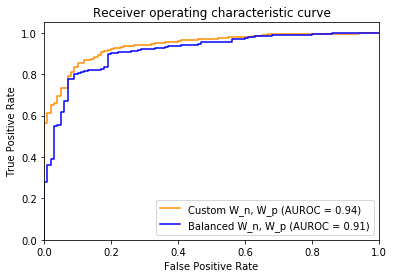

In [10]:
#q4.4
y_pred=clf.decision_function(IMB_test_features)
fpr, tpr, _ = metrics.roc_curve(IMB_test_labels, y_pred)
#balanced weights
clf1 = select_classifier(c=0.01, class_weight={-1: 1, 1:1})
clf1.fit(IMB_features, IMB_labels)
y_pred1=clf1.decision_function(IMB_test_features)
fpr1, tpr1, _ = metrics.roc_curve(IMB_test_labels, y_pred1)
perf1=performance(IMB_test_labels, y_pred1, metric="auroc")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='Custom W_n, W_p (AUROC = %0.2f)' % perf)
plt.plot(fpr1, tpr1, color='blue', label='Balanced W_n, W_p (AUROC = %0.2f)' % perf1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()